In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import os

import serial_data_formatter as sdf

plt.style.use("bmh")

The raw eval software output is then parsed to extract the capacitance data and some header information. The EvalBoardData object hold this information along with some stuff like generating timestamps.

The capacitance data is stored as raw ADC counts in decimal. 

In [2]:
data_directory = os.path.join(os.getcwd(), "data", "conversion_rate")
trials = sdf.format_folder(data_directory)

In [3]:
def count2ff(counts):
    """24bit resolution measuring +/- 4.096 pF"""
    zero = 2**23
    return (counts - zero)*(4096/zero)


Two types of trials so far, cyclic loading and trials without any input.

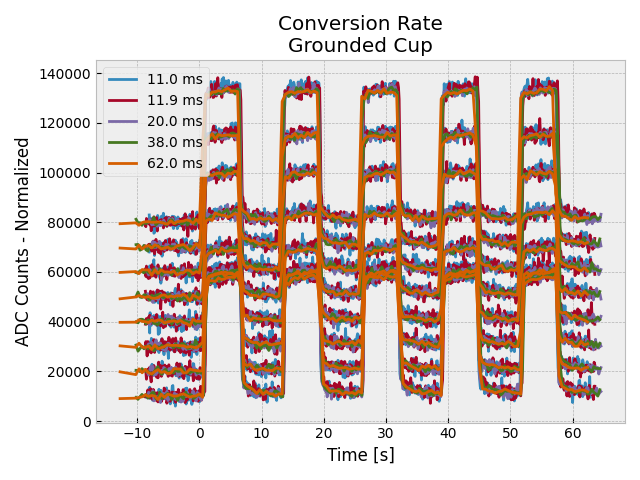

In [12]:
conversion_codes = {
    "000": 11.0,
    "001": 11.9,
    "010": 20.0,
    "011": 38.0,
    "100": 62.0,
}
fig, axs = plt.subplots(1)

for idx, trial in enumerate(trials):
    code = trial.name.split("_")[-1].split(".")[0]
    label = f"{conversion_codes[code]} ms"

    axs.plot(trial.time-trial.time[trial.actuation_starts[0]], trial.normalize(trial.cap_counts) + (np.arange(8) + 1)*10000, color = f"C{idx}", alpha=1, label = label)
    axs.set_xlabel("Time [s]")
    axs.set_ylabel("ADC Counts - Normalized")
    axs.set_title("Conversion Rate\nGrounded Cup")

handles, labels = axs.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs.legend(by_label.values(), by_label.keys())



plt.tight_layout()

Text(0.5, 1.0, 'SNR vs. Conversion Rate\n3mm Deflection')

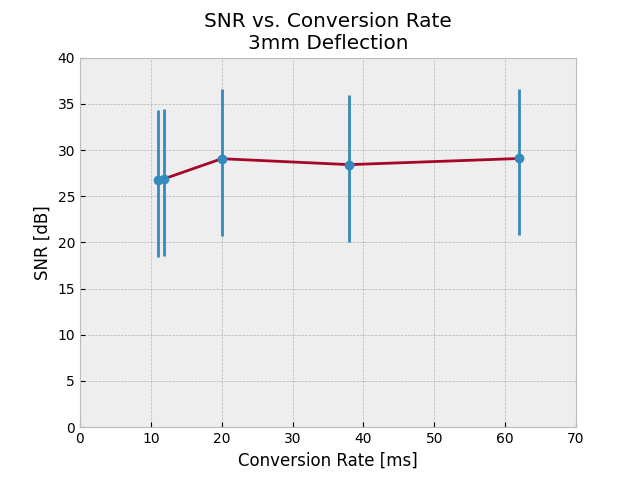

In [29]:
SNRs = []
for trial in trials:
    baselines = []
    steps = []
    std_data = np.empty((0, 8))

    for idx, (start, end) in enumerate(zip(trial.segment_starts, trial.segment_ends)):
        magnitude = np.mean(trial.cap_counts[start:end], axis=0)
        if idx % 2 == 0:
            baselines.append(magnitude)
        else:
            steps.append(magnitude)
        
        std_data = np.r_[std_data, trial.cap_counts[start:end] - magnitude]

    changes = np.array(steps) - np.array(baselines)
    channel_stds = np.std(std_data, axis=0)
    SNR = 20 * np.log10(changes / channel_stds)
    SNRs.append(SNR.flatten())
    # print(trial.name, "SNR:", np.median(SNRs))

    # code = trial.name.split("_")[-1].split(".")[0]
    


fig, ax = plt.subplots()
# x axis is conversion rates. y axis for each x is the highest, lowest, and median SNR across all channels and all actuations
y_err_hi = np.max(SNRs) - np.median(SNRs)
y_err_lo = np.median(SNRs) - np.min(SNRs)
ax.errorbar(conversion_codes.values(), np.median(SNRs, axis=1), yerr = np.array([[y_err_lo], [y_err_hi]]), fmt='o')
ax.plot(conversion_codes.values(), np.median(SNRs, axis=1))
ax.set_ylim(0, 40)
ax.set_xlim(0, 70)
ax.set_xlabel("Conversion Rate [ms]")
ax.set_ylabel("SNR [dB]")
ax.set_title("SNR vs. Conversion Rate\n3mm Deflection")